# MLP

This notebook provides scripts that load data, create synthetic dataset and test different MLP models on it.

## Load Package & Initialization

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Import the synthetic sample generation function (with noise) from our module
from module import generate_synthetic_samples_for_class
from load_dataset import load_from_path
from plot import plot_fold_accuracies, plot_learning_curve, plot_feature_importance

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Data Loading & Filtering
Function load_from_path is pre-defined to perform all data loading tasks together

In [4]:
data_path = "../Data/AllFishCombined_filtered.csv"
df = load_from_path(data_path, ['LT', 'SMB'], ['LT008', 'LT016'])
print(df.head())

    fishNum Spe  Index       Ping_time        F45      F45.5        F46  \
288   LT001  LT      1   20:57:29.4800 -36.179106 -36.156327 -36.151127   
289   LT001  LT      1   20:57:29.6040 -36.436682 -36.318622 -36.159983   
290   LT001  LT      1   20:57:29.7290 -36.143429 -35.675405 -35.183430   
291   LT001  LT      1   20:57:29.8560 -34.455303 -34.397209 -34.375414   
292   LT001  LT      1   20:57:29.9910 -40.787544 -41.273102 -41.783685   

         F46.5        F47      F47.5  ...     F255.5       F256     F256.5  \
288 -35.777926 -35.799611 -35.608905  ... -22.723915 -22.488092 -22.628031   
289 -35.669801 -35.567145 -35.251859  ... -14.608002 -13.226696 -12.105007   
290 -34.451909 -34.228203 -33.938008  ... -23.780087 -21.908773 -19.930888   
291 -34.086497 -34.233998 -34.328222  ... -36.139492 -34.982741 -34.258071   
292 -41.943936 -42.432228 -42.722720  ... -26.510093 -27.092194 -27.751359   

          F257     F257.5       F258     F258.5       F259     F259.5  \
288 -22

### Counting Samples

In [5]:
class_counts = df['Spe'].value_counts()
fish_counts = df['fishNum'].value_counts()

print("Class Counts:")
print(class_counts)
print("\nIndividual Fish Counts:")
print(fish_counts)

Class Counts:
Spe
LT     29321
SMB    16148
Name: count, dtype: int64

Individual Fish Counts:
fishNum
SMB001    4097
LT003     3983
SMB006    3912
LT014     3886
LT015     3182
LT009     2977
LT013     2540
SMB002    2004
LT010     1932
LT011     1878
SMB004    1804
LT012     1534
LT002     1502
LT004     1066
LT017     1040
SMB003    1034
SMB005    1014
SMB008     739
LT007      729
SMB007     636
LT019      609
LT020      585
LT005      585
LT001      485
SMB013     440
LT021      364
LT006      320
SMB012     183
SMB010     159
LT018      124
SMB011      95
SMB009      31
Name: count, dtype: int64


### Synthetic Sample Generation
A distinct module is designed to create synthetic datasets for chosen classes

In [6]:
# Set desired sample sizes and noise level
desired_samples_LT = 1000    # Desired number of synthetic samples for class 'LT'
desired_samples_SMB = 1000   # Desired number of synthetic samples for class 'SMB'
noise_std = 1                # Standard deviation for the added Gaussian noise

# Generate synthetic samples for each class
synthetic_LT_df = generate_synthetic_samples_for_class(df, 'LT', desired_samples_LT, noise_std)
synthetic_SMB_df = generate_synthetic_samples_for_class(df, 'SMB', desired_samples_SMB, noise_std)

# Concatenate synthetic datasets from both classes
synthetic_df = pd.concat([synthetic_LT_df, synthetic_SMB_df], ignore_index=True)

# Display the first few rows of the synthetic dataset
# print(synthetic_df.head())

### Data Preparation
Prepare the dataframes and torch tensors for models to use

In [7]:
# List of columns to drop from synthetic_df
drop_cols = ['fishNum', 'Spe', 'Index', 'Ping_time']

# Separate features (X) and target (y) from the synthetic data
X_synth = synthetic_df.drop(columns=drop_cols, errors='ignore')
y_synth = synthetic_df['Spe']

# Standardize features using StandardScaler
scaler = StandardScaler()
X_synth_scaled = scaler.fit_transform(X_synth)

# Convert features to a torch tensor (float32) and move to device
X_synth_tensor = torch.tensor(X_synth_scaled, dtype=torch.float32).to(device)

# Map target labels 'LT' and 'SMB' to numeric values, e.g., 'LT' -> 0 and 'SMB' -> 1
label_map = {'LT': 0, 'SMB': 1}
y_synth_numeric = y_synth.map(label_map).values
y_synth_tensor = torch.tensor(y_synth_numeric, dtype=torch.long).to(device)

input_dim = X_synth_tensor.shape[1]

# Preprocess the original data using the same scaler.
X_orig = df.drop(columns=drop_cols, errors='ignore')
y_orig = df['Spe']
X_orig_scaled = scaler.transform(X_orig)
X_orig_tensor = torch.tensor(X_orig_scaled, dtype=torch.float32).to(device)
y_orig_numeric = y_orig.map(label_map).values
y_orig_tensor = torch.tensor(y_orig_numeric, dtype=torch.long).to(device)


### Function: train_and_evaluate_model

A function that modularizes the process of training and evaluating a 1-D MLP based model, which simplifies the process when testing different models.

In [8]:
def average_models(model_list, model_fn, device):
    """
    Averages the parameters (state_dicts) of a list of models and returns a new model with averaged parameters.
    
    Parameters:
        model_list (list): List of trained models (nn.Module) with identical architecture.
        model_fn (function): A function that returns a new instance of the model.
        device (torch.device): The device on which to place the final model.
    
    Returns:
        final_model (nn.Module): A new model instance whose parameters are the average of those in model_list.
    """
    # Get the keys from the first model's state dict
    avg_state_dict = {}
    state_dicts = [model.state_dict() for model in model_list]
    for key in state_dicts[0].keys():
        # Sum the corresponding tensors across models
        avg_state_dict[key] = sum(state_dict[key] for state_dict in state_dicts) / len(state_dicts)
    # Create new model and load the averaged state dict
    final_model = model_fn().to(device)
    final_model.load_state_dict(avg_state_dict)
    return final_model

def train_and_evaluate_model(model_fn, X, Y, kf, num_epochs = 100, lr = 0.001, l1_lambda=0, device=torch.device("cpu")):
    """
    Trains a model (constructed via model_fn) using SGD with optional L1 regularization,
    performs K-Fold cross-validation while recording training and validation losses,
    and then produces a final model by averaging the parameters from each fold.
    
    Parameters:
        model_fn (function): A function that returns a new model instance.
        X (torch.Tensor): The features.
        Y (torch.Tensor): The target labels.
        kf (sklearn.model_selection.KFold): An instance of KFold for splitting the data.
        num_epochs (int): Number of epochs for training on each fold.
        lr (float): Learning rate for SGD.
        l1_lambda (float, optional): Coefficient for L1 regularization (default=0).
        device (torch.device): Device to run on (e.g., CPU or CUDA).
        
    Returns:
        fold_accuracies (list): List of validation accuracies (one per fold).
        all_fold_train_losses (list): List of training loss lists (one per fold, losses per epoch).
        all_fold_val_losses (list): List of validation loss lists (one per fold, losses per epoch).
        final_model (nn.Module): The final model produced by averaging parameters from each fold.
    """
    fold_accuracies = []
    all_fold_train_losses = []
    all_fold_val_losses = []
    fold_models = []  # To store the final model from each fold
    
    criterion = nn.CrossEntropyLoss()
    fold_num = 1
    for train_index, val_index in kf.split(X):
        X_train = X[train_index]
        Y_train = Y[train_index]
        X_val = X[val_index]
        Y_val = Y[val_index]
        
        model = model_fn().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        
        fold_train_losses = []
        fold_val_losses = []
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, Y_train)
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm
            loss.backward()
            optimizer.step()
            fold_train_losses.append(loss.item())
            
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, Y_val)
                if l1_lambda > 0:
                    l1_norm_val = sum(p.abs().sum() for p in model.parameters())
                    val_loss = val_loss + l1_lambda * l1_norm_val
                fold_val_losses.append(val_loss.item())
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            _, predicted = torch.max(val_outputs, 1)
            acc = (predicted == Y_val).float().mean().item()
        fold_accuracies.append(acc)
        all_fold_train_losses.append(fold_train_losses)
        all_fold_val_losses.append(fold_val_losses)
        fold_models.append(model)
        print(f"Fold {fold_num} Accuracy: {acc:.4f}")
        fold_num += 1

    print("\nMean CV Accuracy: {:.4f}".format(np.mean(fold_accuracies)))
    
    # Average the parameters from the fold models.
    average_model = average_models(fold_models, model_fn, device)

    # Train final model on the entire dataset.
    final_model = model_fn().to(device)
    optimizer = optim.SGD(final_model.parameters(), lr=lr, momentum=0.9)
    for epoch in range(num_epochs):
        final_model.train()
        optimizer.zero_grad()
        outputs = final_model(X)
        loss = criterion(outputs, Y)
        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in final_model.parameters())
            loss = loss + l1_lambda * l1_norm
        loss.backward()
        optimizer.step()
    
    
    return fold_accuracies, all_fold_train_losses, all_fold_val_losses, average_model, final_model

## Model Setup
### Define PyTorch MLP Classifier, Dropout-Based MLP and MLP with L1 Regularization

In [9]:
# An MLP with three hidden layers: 64, 32, 16 neurons, and an output layer with 2 neurons
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # two outputs for two classes
        )
    
    def forward(self, x):
        return self.net(x)

# A Dropout-Based MLP which prevents overfitting by dropping 50% of each hidden layer.
class MLP_Dropout(nn.Module):
    def __init__(self, input_dim):
        super(MLP_Dropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),       # Dropout with 50% probability
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),       # Another dropout layer
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)       # Output layer with 2 classes
        )
    
    def forward(self, x):
        return self.net(x)

class MLP_L1(nn.Module):
    def __init__(self, input_dim):
        super(MLP_L1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # 2 outputs for 2 classes
        )
    
    def forward(self, x):
        return self.net(x)

### Define Training Parameters and KFold

In [10]:
# Parameters
num_epochs = 2000
learning_rate = 0.001
l1_lambda = 0.001  # Set to a positive value to enforce L1 regularization; set 0 to disable L1.

# Create a KFold instance (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

## Model Training
Using train_and_evaluate_model function on regular MLP

In [11]:
# The model constructor function: takes no parameters (assumes input_dim is defined in closure)
def model_original():
    return MLP(input_dim)

fold_accuracies, all_fold_train_losses, all_fold_val_losses, average_model, final_model = train_and_evaluate_model(
    model_original, X_synth_tensor, y_synth_tensor, kf, num_epochs, learning_rate, 0, device # l1_lambda is set to 0
)

Fold 1 Accuracy: 0.7275
Fold 2 Accuracy: 0.6950
Fold 3 Accuracy: 0.6950
Fold 4 Accuracy: 0.7450
Fold 5 Accuracy: 0.7250

Mean CV Accuracy: 0.7175


### Results Plotting
Plot the training-validation loss curves

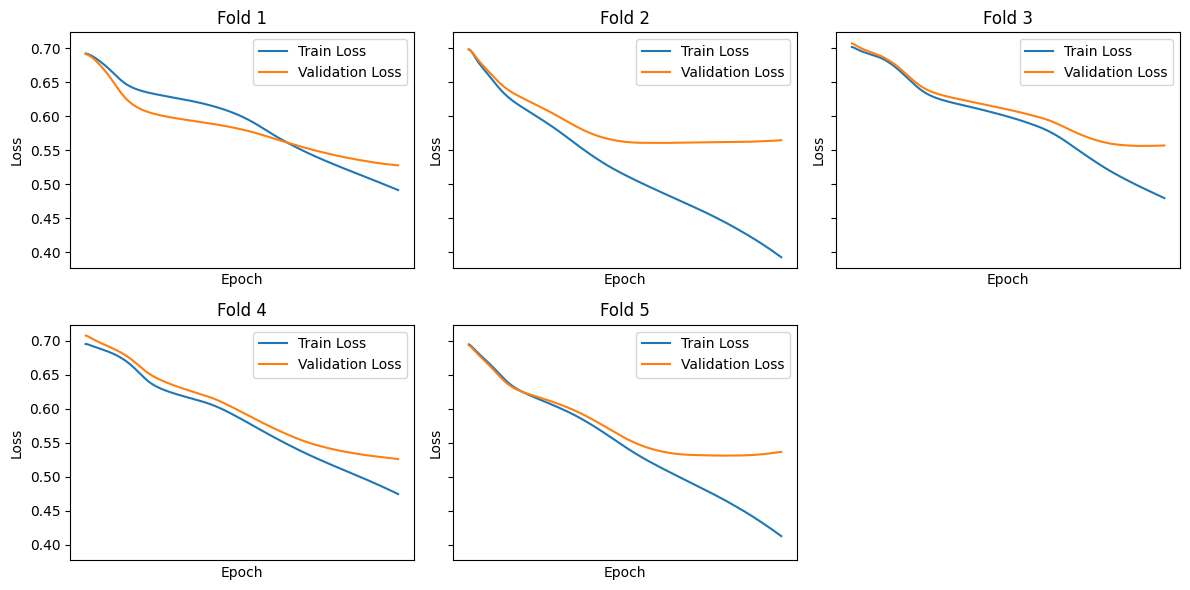

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
axes = axes.ravel()

for fold in range(5):
    plot_learning_curve(axes[fold], all_fold_train_losses[fold], all_fold_val_losses[fold], fold+1)
if len(axes) > 5:
    axes[5].axis('off')

plt.tight_layout()
plt.show()

Plot the accuracies for each fold

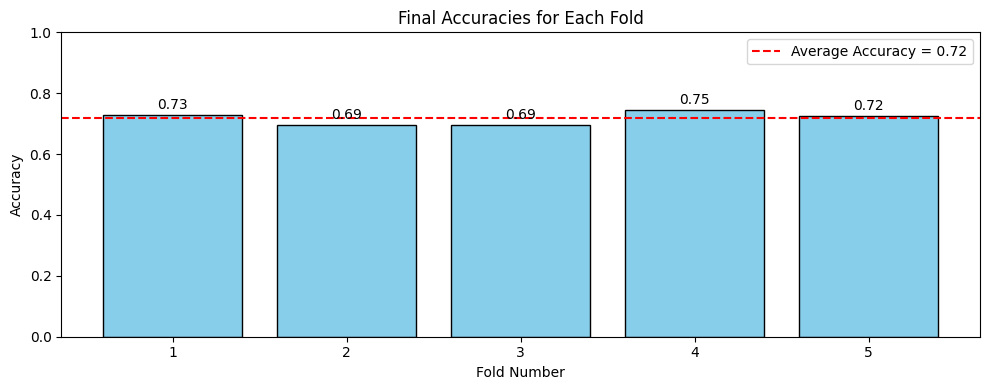

In [13]:
plot_fold_accuracies(fold_accuracies)

### Evaluate the final model on the original (real-world) data

In [14]:
final_model.eval()
with torch.no_grad():
    orig_outputs = final_model(X_orig_tensor)
    _, orig_predicted = torch.max(orig_outputs, 1)
    orig_acc = (orig_predicted == y_orig_tensor).float().mean().item()
print("\nAccuracy on Original Data (Full Model): {:.4f}".format(orig_acc))


Accuracy on Original Data (Full Model): 0.6478


### Estimate Feature Importance (Heuristic)
Extract the feature importance using a heuristic, summing the absolute weights of the first layer

In [15]:
# Move the weights to CPU to compute and inspect.
input_layer_full = final_model.net[0]  # first nn.Linear layer
weights_full = input_layer_full.weight.detach().cpu().numpy()  # shape: (64, input_dim)
feature_importance_full = np.abs(weights_full).sum(axis=0)  # sum weights from each input feature

importance_full_df = pd.DataFrame({
    'Feature': X_synth.columns,
    'Importance': feature_importance_full
}).sort_values(by='Importance', ascending=False)

print(importance_full_df.head(10))

    Feature  Importance
259  F257.5    2.695805
126    F191    2.370403
3     F46.5    2.355592
122    F189    2.338028
33    F61.5    2.330368
184    F220    2.318034
111  F183.5    2.316281
110    F183    2.313048
2       F46    2.305181
166    F211    2.282381


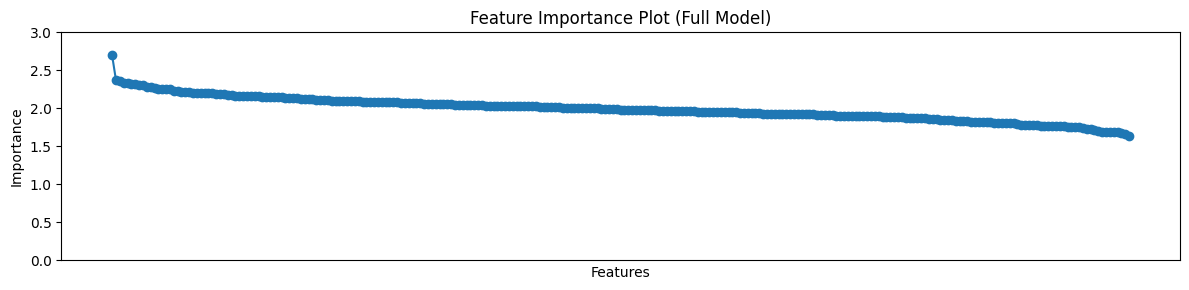

In [16]:
plot_feature_importance(importance_full_df, 'Feature Importance Plot (Full Model)', 3)

In [17]:
input_layer_avg = average_model.net[0] 
weights_avg = input_layer_avg.weight.detach().cpu().numpy()
feature_importance_avg = np.abs(weights_avg).sum(axis=0)

importance_avg_df = pd.DataFrame({
    'Feature': X_synth.columns,
    'Importance': feature_importance_avg
}).sort_values(by='Importance', ascending=False)

print(importance_avg_df.head(10))

    Feature  Importance
11    F50.5    1.028238
47    F68.5    1.023405
8       F49    1.000575
82      F86    1.000281
233  F244.5    0.994630
217  F236.5    0.993592
95   F175.5    0.992645
2       F46    0.987276
31    F60.5    0.980350
212    F234    0.974762


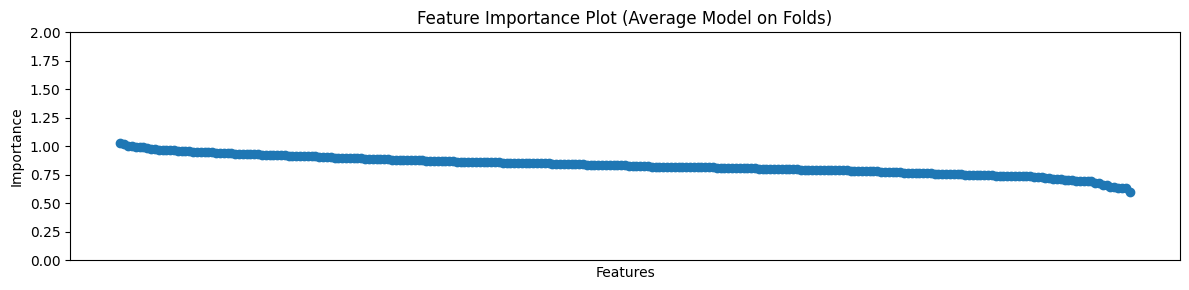

In [18]:
plot_feature_importance(importance_avg_df, 'Feature Importance Plot (Average Model on Folds)', 2)

### MLP with L-1 Regulation
Doing the same, except now this MLP has L-1 regulation to force feature selection

In [19]:
def model_L1():
    return MLP_L1(input_dim)

fold_accuracies, all_fold_train_losses, all_fold_val_losses, average_model, final_model = train_and_evaluate_model(
    model_L1, X_synth_tensor, y_synth_tensor, kf, num_epochs, learning_rate, l1_lambda, device
)

Fold 1 Accuracy: 0.7250
Fold 2 Accuracy: 0.7050
Fold 3 Accuracy: 0.7225
Fold 4 Accuracy: 0.7575
Fold 5 Accuracy: 0.7325

Mean CV Accuracy: 0.7285


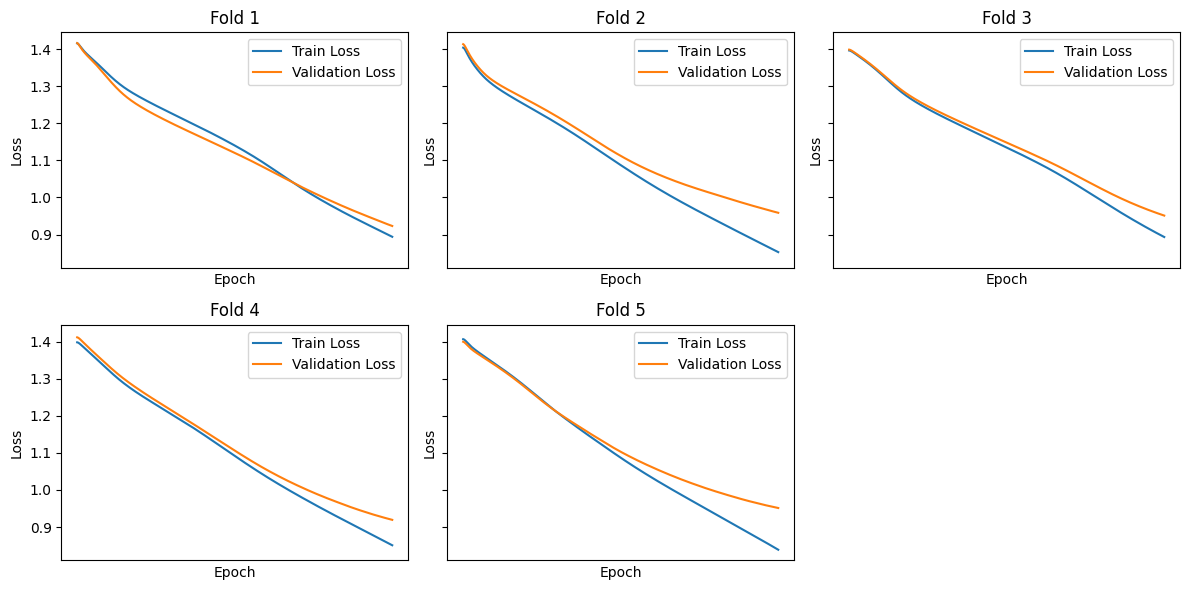

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
axes = axes.ravel()

for fold in range(5):
    plot_learning_curve(axes[fold], all_fold_train_losses[fold], all_fold_val_losses[fold], fold+1)
if len(axes) > 5:
    axes[5].axis('off')

plt.tight_layout()
plt.show()

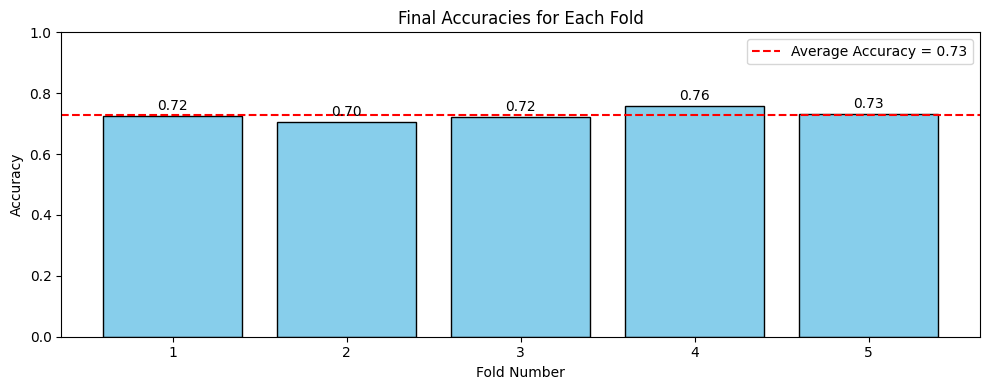

In [21]:
plot_fold_accuracies(fold_accuracies)

In [22]:
final_model.eval()
with torch.no_grad():
    orig_outputs = final_model(X_orig_tensor)
    _, orig_predicted = torch.max(orig_outputs, 1)
    orig_acc = (orig_predicted == y_orig_tensor).float().mean().item()
print("\nAccuracy on Original Data: {:.4f}".format(orig_acc))


Accuracy on Original Data: 0.6494


In [23]:
input_layer_full = final_model.net[0]  # first nn.Linear layer
weights_full = input_layer_full.weight.detach().cpu().numpy()  # shape: (64, input_dim)
feature_importance_full = np.abs(weights_full).sum(axis=0)  # sum weights from each input feature

importance_full_df = pd.DataFrame({
    'Feature': X_synth.columns,
    'Importance': feature_importance_full
}).sort_values(by='Importance', ascending=False)

print(importance_full_df.head(10))

    Feature  Importance
31    F60.5    1.286196
1     F45.5    1.283650
17    F53.5    1.243487
107  F181.5    1.220395
26      F58    1.218417
25    F57.5    1.215025
260    F258    1.210979
10      F50    1.204663
4       F47    1.200059
14      F52    1.193628


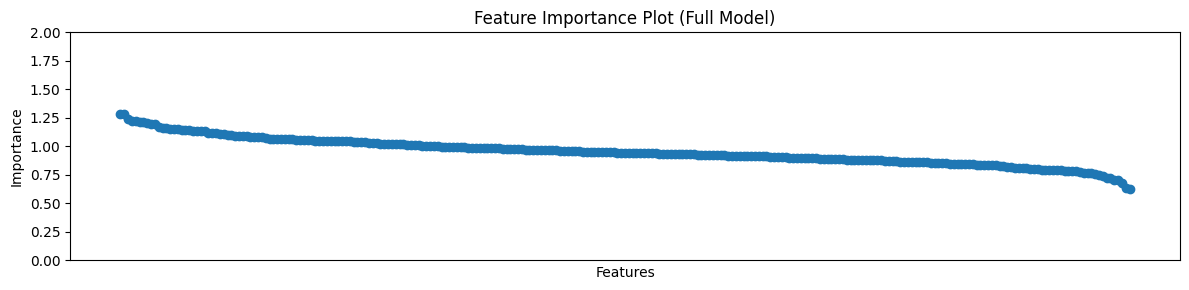

In [24]:
plot_feature_importance(importance_full_df, 'Feature Importance Plot (Full Model)', 2)